In [2]:
# run only if you have not installed the next libraries
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install getdist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
from getdist import plots, MCSamples
%matplotlib inline

# Gradiente de U
$U = -\log(L(\textbf{q})p(\textbf{q})) = - \log(L) -  \log(p)$

$\nabla_{q} U = -\frac{1}{L}\frac{\partial L}{\partial q} - \frac{1}{p}\frac{\partial p}{\partial q} = -\frac{1}{L}\frac{\partial L}{\partial q}$

Si el prior $p$ es uniforme, $\frac{\partial p}{\partial q} = 0$

$\frac{\partial L}{\partial q} = \frac{\partial}{\partial q}(N\exp(-\frac{\chi^{2}}{2})) = -N \chi \exp(-\frac{\chi^{2}}{2})\frac{\partial \chi}{\partial q}$

$\frac{\partial \chi}{\partial q} = \frac{\partial}{\partial q}(A - \frac{B^{2}}{C}) = \frac{\partial A}{\partial q} - 2\frac{B}{C} \frac{\partial B}{\partial q}$

$\frac{\partial A}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)^{2}}{\sigma_{i}^{2}}) = -\sum_{i}\frac{2(\mu_{i} - \mu)}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\frac{\partial B}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)}{\sigma_{i}^{2}}) = - \sum_{i} \frac{1}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\frac{\partial \mu}{\partial q} = \frac{\partial}{\partial q} (5 \log_{10}(\bar{d}_{L})) = \frac{5}{\log{10}} \frac{1}{\bar{d}_{L}} \frac{\partial \bar{d}_{L}}{\partial q}$

$\frac{\partial \bar{d}_{L}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{L}}{d_{H}}) = \frac{1}{d_{H}} \frac{\partial d_{L}}{\partial q}$

$\frac{\partial d_{L}}{\partial q} = \frac{\partial}{\partial q}((1 + z)\, d_{M}) = (1 + z)\frac{\partial }{}$

In [51]:
# Este programa implementa Hamiltonian Markov Chain Monte Carlo. El núcleo utilizado se basa en Metropolis Hastings.

def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # log(pi)
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) - 0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta(ec, ep, EC, EP, x, X):
    alpha = min(- EP - EC + ep + ec, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return X, EP
    else:
        return x, ep


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta,z): # modulo de la distancia teorico
    om0 = theta[0]
    ol = theta[1]
    omega_k = 1 - om0 - ol
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/E, z, initial=0)+z[0]*((1/E)[0] + 1)/2
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/o_k_s
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/o_k_s	
    dist = 5*np.log10(dl)
    if (-np.inf==dist).any(): 
        print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    print(bol)
    if bol>0:
        a = 0 # raiz imaginaria 
    else:
        a = 1 # raiz real
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def potencial(dat, sigma, theta, z):
    mod = modelo(theta, z)
    u = - likelihood(mod, dat, sigma) - prior(theta) 
    return u


def cinetica(p, m):
    k = np.sum(p**2/2/m)
    return k


def hamiltoniano(p, dat, sigma, theta, z, m=1):
    h = cinetica(p, m) + potencial(dat, sigma, theta, z)
    return h


def gradiente(dw, theta, z, dat, sigma):
    tf = theta + 0.5*dw
    tb = theta - 0.5*dw
    grad = (potencial(dat, sigma, tf, z) - potencial(dat, sigma, tb, z))/dw
    return grad


def leapfrog(l, e, dw, theta, m, z, dat, sigma):
    qe = theta
    while True:
        pi = np.random.multivariate_normal(mean=np.zeros(3), cov=np.diag(m))
        pe = pi
        X = []
        P = []
        X.append(theta)
        P.append(pe)
        for i in range(l):            
            rev = revisa1(qe)*revisa1(qe + 0.5*dw)*revisa1(qe - 0.5*dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            if rev:
                break            
            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma) # actualiza momento en e/2	
            qe = qe + e*pe/m            
            rev = revisa1(qe)*revisa1(qe + 0.5*dw)*revisa1(qe - 0.5*dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            if rev:
                break            
            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma)
            P.append(pe)
            X.append(qe)
            if i+1==l: 
                i+=1
        if i==l: 
            break
    P = np.array(P)
    X = np.array(X)
    return X, P


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0

In [52]:
# saved things directory
direc = '/home/mauricio/Documents/Uni/Intro_2/' + 'gal.txt'

# Carga de datos
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M
cov = np.genfromtxt('gal.txt', usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)

In [53]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

M = 1 # numero de cadenas
Chains = []
Xi2 = []
Post = []
COV = []
params = 3 # numero de parametros
r = 0.75e-2 #0.75e-2
m = np.array([0.5, 0.5, 1])*r  # np.ones(3)*r # (np.array([0.4, 1.125, 4])**2)*1e-2  
pg = 1e-5 # paso gradiente # 0.5
ps = pg*10 # paso solver
'numero de parametros', params
L = 5
print('pasos solver:', L)


pasos solver: 5


In [55]:
N = 2000
print('numero de muestras:', N)

# q inicial, revisa que sea valido
while True:
    q = np.random.uniform(low=[0,0,-5], high=[1, 1, 1/3], size=3)
    q = np.array([0.89595746, 0.79052363, 0.22899774])
    if revisa1(q):
        break
    #if revisa(q,redshift)==1: 
     #   break

print('params iniciales', q)

# Matrices de datos de la cadena
chain = [] 
post = [] 
chi_2 = []
Ratio = []
H = []
acept = 0
mod1 = modelo(q, redshift)
pos1 = potencial(mu_obs, cov, q, redshift)
Chi1 = chi2(mod1, mu_obs, cov)[0]
chain.append(q)
post.append(pos1)
chi_2.append(Chi1)
Ratio.append(100)

Ti = time.time()
for i in range(N):
    print(i)
    q = chain[i]
    # revision si proposal no indefine la busqueda
    while True:	
        Q, P = leapfrog(L, ps, pg, q, m, redshift, mu_obs, cov)	
        Q1 = Q[-1]
        P1 = P[-1]
        if revisa1(Q1):
            break
        #if revisa(Q1, redshift)==1: # que la raiz no sea imaginaria
         #   break
    H.append(Q)
    t = cinetica(P1[0], m)
    u = potencial(mu_obs, cov, q, redshift)
    T = cinetica(P1, m)
    U = potencial(mu_obs, cov, Q1, redshift)
    A = acepta(t, u, T, U, q, Q1)
    chain.append(A[0])
    post.append(A[1])
    mod1 = modelo(A[0], redshift)
    Chi1 = chi2(mod1, mu_obs, cov)[0]
    chi_2.append(Chi1)	
    # ratio de aceptacion
    acept += tasa(chain[i], chain[i + 1]) 
    Ratio.append(acept/(i+1)*100)

Tf = time.time()
print('Tiempo cadena', np.around(Tf - Ti, 0), 's')

ratio = acept/N*100
print('ratio %', np.rint(ratio))

post = np.array(post)
chain = np.array(chain)
chi_2 = np.array(chi_2)
Ratio = np.array(Ratio)
H = np.array(H)

t1 = chain[:,0]
t2 = chain[:,1]
t3 = chain[:,2]

# busca argumento del minimo de chi2
t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
print('Xi2 minimo', t1m, t2m, t3m)

numero de muestras: 2000
params iniciales [0.89595746 0.79052363 0.22899774]
0


KeyboardInterrupt: 

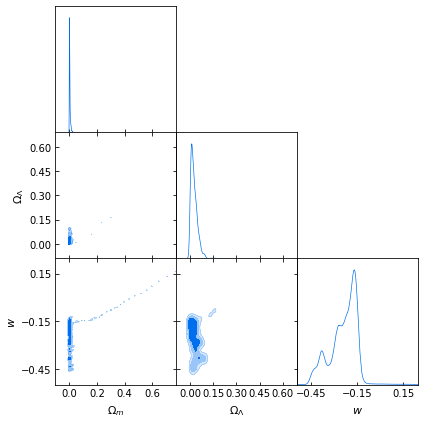

In [46]:
#Get the getdist MCSamples objects for the samples, specifying same parameter
#names and labels; if not specified weights are assumed to all be unity
ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)

In [39]:
q = np.array([-0.02474671, -0.15258245, -0.27300482])
E, E_arg = EHubble(q, redshift)
print(E_arg<0)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa